In [1]:
import numpy as np # numerical computing 
import pandas as pd # data analysis, working with DataFrames
import matplotlib.pyplot as plt # visualizations
import seaborn as sns # visulizations ++
import tensorflow as tf # our main library, deep learning modellign
from tensorflow import keras # keras library
from tensorflow.keras import layers # for creating layers

In [2]:
df = pd.read_csv("spam.csv", encoding="latin-1") # reading data

In [3]:
df.head() # an overview 

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1':'label', 'v2':'Text'})
df['label_in_num'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_in_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Analysis of Data

<AxesSubplot:xlabel='label', ylabel='count'>

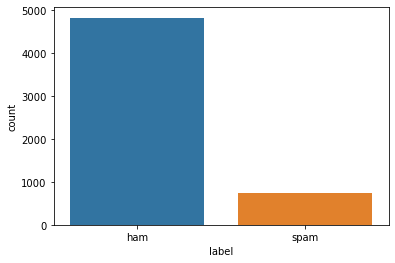

In [5]:
sns.countplot(x=df['label']) # countplot for label

In [6]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Text(0.5, 0, 'Text length')

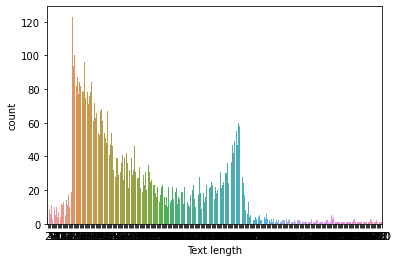

In [7]:
sns.countplot(x=[len(df.loc[i]['Text']) for i in range(len(df))])
plt.xlabel('Text length')

In order to find the; 
* number of words in the whole dataset
* mean of word count in every row
* total words in dataset

We use:

In [8]:
text_words_lengths = [len(df.loc[i]['Text'].split()) for i in range(0, len(df))]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))
print('we have ' + str(total_length) + ' words in our Dataframe')
print('the average word count in every scentence is ' + str(text_words_mean))
text_words_lengths[:5], total_length, text_words_mean

we have 86335 words in our Dataframe
the average word count in every scentence is 15


([20, 6, 28, 11, 13], 86335, 15)

We then train_test_split

In [9]:
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_in_num'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
len(X_train), len(X_test), X_train[:2], y_train[:2]

(4457,
 1115,
 array(['Kallis wont bat in 2nd innings.',
        'Ringtone Club: Get the UK singles chart on your mobile each week and choose any top quality ringtone! This message is free of charge.'],
       dtype=object),
 array([0, 1], dtype=int64))

Random Forest

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# TFIDF preprocessing the text data

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec, X_test_vec = tfidf_vec.transform(X_train), tfidf_vec.transform(X_test)
baseline_model = RandomForestClassifier(n_estimators=250)
baseline_model.fit(X_train_vec, y_train)

random_forest_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       971
           1       1.00      0.84      0.91       144

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


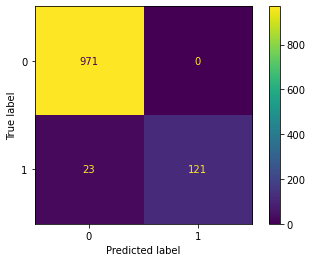

In [11]:
# confusino matrix for baseline model


from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(baseline_model, X_test_vec, y_test)

Text Vectorization and Word Embedding

In [12]:
MAXTOKENS = total_length
OUTPUTLEN = text_words_mean

text_vec = layers.TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)

text_vec.adapt(X_train)

In [13]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

Model 1

Using our custom layers with 2 Dense layers

In [14]:
# Input layer
input_layer = layers.Input(shape=(1,), dtype=tf.string)
# Text Vectorizatino layer
vec_layer = text_vec(input_layer)
# Embedding layer
embedding_layer_model = embedding_layer(vec_layer)
# Global Average Pooling layer
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
# Flatten layer for Dense layers
x = layers.Flatten()(x)
# 32 units dense layer
x = layers.Dense(32, activation='relu')(x)
# output layer with sigmoid activation function
output_layer = layers.Dense(1, activation='sigmoid')(x)
# final model
model_1 = keras.Model(input_layer, output_layer)

In [15]:
model_1.compile(optimizer=keras.optimizers.Adam(),
               loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
               metrics=['accuracy'])

In [16]:
history_1 = model_1.fit(X_train,
           y_train,
           epochs=5,
           validation_data=(X_test, y_test),
           validation_steps=int(0.2 * len(X_test)))

Epoch 1/5
140/140 [==============================] - 14s 94ms/step - loss: 0.6030 - accuracy: 0.9177 - val_loss: 0.5751 - val_accuracy: 0.9776
Epoch 2/5
140/140 [==============================] - 13s 94ms/step - loss: 0.5700 - accuracy: 0.9879 - val_loss: 0.5717 - val_accuracy: 0.9865
Epoch 3/5
140/140 [==============================] - 13s 94ms/step - loss: 0.5659 - accuracy: 0.9953 - val_loss: 0.5715 - val_accuracy: 0.9865
Epoch 4/5
140/140 [==============================] - 13s 95ms/step - loss: 0.5643 - accuracy: 0.9978 - val_loss: 0.5717 - val_accuracy: 0.9857
Epoch 5/5
140/140 [==============================] - 13s 96ms/step - loss: 0.5635 - accuracy: 0.9987 - val_loss: 0.5715 - val_accuracy: 0.9830


<AxesSubplot:>

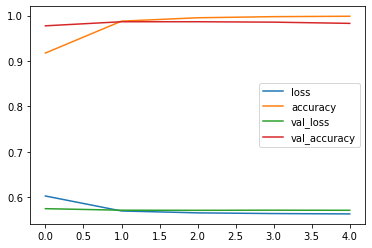

In [17]:
pd.DataFrame(history_1.history).plot()

compile_model(), fit_model(), evaluate_model():
To compile, fit and evaluate for a few models, this method is able to easily reuse the code over and over.

In [18]:
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])    

def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train and test data
    '''
    history = model.fit(X_train,
              y_train,
             epochs=epochs,
             validation_data=(X_test, y_test),
             validation_steps=int(0.2*len(X_test)))
    return history
 

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy, precision, recall and f1-score 
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    
    model_results_dict = {'accuracy':accuracy,
                         'precision':precision,
                         'recall':recall,
                         'f1-score':f1}
    
    return model_results_dict

Model 2

Bidirectional LSTM 

In [20]:
input_layer = layers.Input(shape=(1,), dtype=tf.string) # Input layer, string type(text)
vec_layer = text_vec(input_layer) # text vectorization layer(built previous lines)
embedding_layer_model = embedding_layer(vec_layer) # word embedding layer
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model) # Bidirectional-LSTM, 64 units
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm) # Flatten layer for enering in dense layers
dropout = layers.Dropout(.1)(flatten) # drop out layer
x = layers.Dense(32, activation='relu')(dropout) # Dense layer
output_layer = layers.Dense(1, activation='sigmoid')(x) # output layer
model_2 = keras.Model(input_layer, output_layer) # final model

In [21]:
compile_model(model_2) # compile the model

history_2 = fit_model(model_2, epochs=5) # fit the model

Epoch 1/5
140/140 [==============================] - 27s 137ms/step - loss: 0.0630 - accuracy: 0.9767 - val_loss: 0.0646 - val_accuracy: 0.9848
Epoch 2/5
140/140 [==============================] - 17s 124ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0731 - val_accuracy: 0.9874
Epoch 3/5
140/140 [==============================] - 18s 126ms/step - loss: 2.2425e-04 - accuracy: 1.0000 - val_loss: 0.1138 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 18s 128ms/step - loss: 2.7322e-05 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 0.9839
Epoch 5/5
140/140 [==============================] - 21s 153ms/step - loss: 1.6422e-05 - accuracy: 1.0000 - val_loss: 0.1221 - val_accuracy: 0.9839


In [22]:
# evaluating the model
model_2.evaluate(X_test, y_test)

35/35 [==============================] - 4s 8ms/step - loss: 0.1221 - accuracy: 0.9839


[0.12214083224534988, 0.9838564991950989]

Model 3

Transfer learning with USE encoder 

In [23]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()
# universal-sentence-encoder layer directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

Compile and Fit the model using our Helper functions

In [24]:
compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 6s 18ms/step - loss: 0.2995 - accuracy: 0.9123 - val_loss: 0.1012 - val_accuracy: 0.9785
Epoch 2/5
140/140 [==============================] - 2s 13ms/step - loss: 0.0853 - accuracy: 0.9773 - val_loss: 0.0588 - val_accuracy: 0.9874
Epoch 3/5
140/140 [==============================] - 2s 13ms/step - loss: 0.0585 - accuracy: 0.9823 - val_loss: 0.0503 - val_accuracy: 0.9857
Epoch 4/5
140/140 [==============================] - 2s 13ms/step - loss: 0.0484 - accuracy: 0.9863 - val_loss: 0.0450 - val_accuracy: 0.9874
Epoch 5/5
140/140 [==============================] - 2s 16ms/step - loss: 0.0421 - accuracy: 0.9888 - val_loss: 0.0432 - val_accuracy: 0.9848


Comparing Models Result

In [25]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'Random-Forest Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()

total_results

35/35 [==============================] - 1s 8ms/step


,accuracy,precision,recall,f1-score
Random-Forest Model,0.979372,1.000000,0.840278,0.913208
Custom-Vec-Embedding Model,0.983857,0.977273,0.895833,0.934783
Bidirectional-LSTM Model,0.983857,0.992188,0.881944,0.933824
USE-Transfer learning Model,0.984753,0.937931,0.944444,0.941176


<AxesSubplot:>

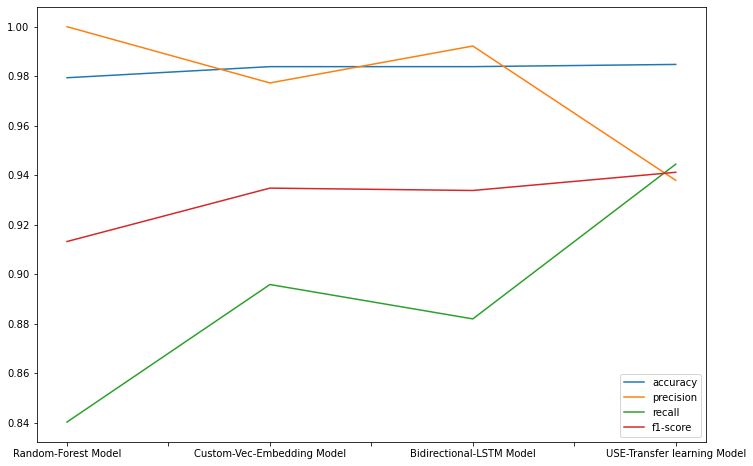

In [26]:
total_results.plot(figsize=(12, 8))

<AxesSubplot:>

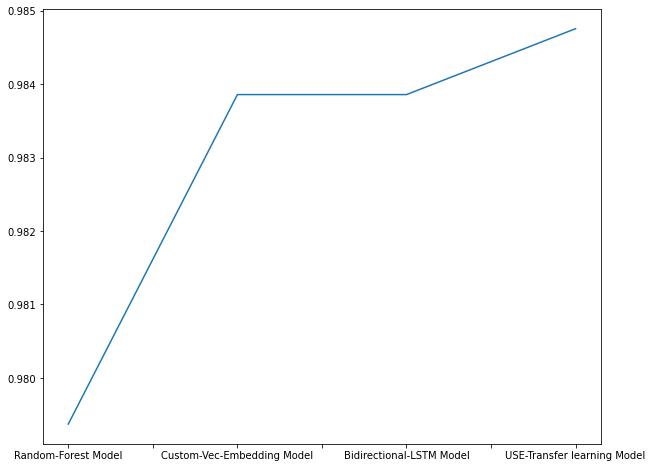

In [27]:
total_results['accuracy'].plot(figsize=(10, 8))

<AxesSubplot:>

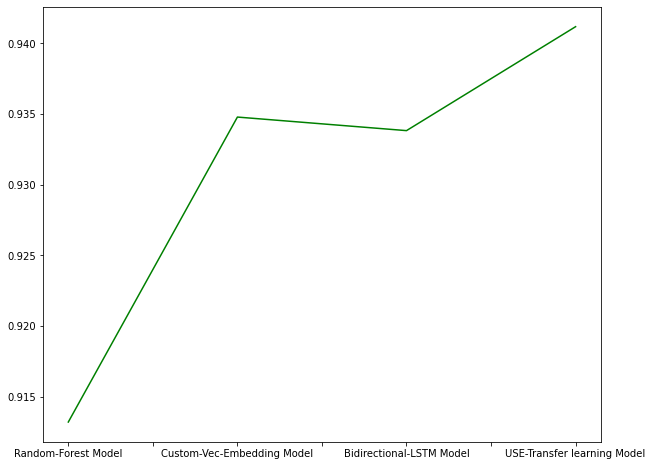

In [28]:
total_results['f1-score'].plot(figsize=(10, 8), color='green')

In [29]:
total_results.sort_values('f1-score', ascending=False)

,accuracy,precision,recall,f1-score
USE-Transfer learning Model,0.984753,0.937931,0.944444,0.941176
Custom-Vec-Embedding Model,0.983857,0.977273,0.895833,0.934783
Bidirectional-LSTM Model,0.983857,0.992188,0.881944,0.933824
Random-Forest Model,0.979372,1.000000,0.840278,0.913208


In [30]:
total_results.sort_values('accuracy', ascending=False)

,accuracy,precision,recall,f1-score
USE-Transfer learning Model,0.984753,0.937931,0.944444,0.941176
Custom-Vec-Embedding Model,0.983857,0.977273,0.895833,0.934783
Bidirectional-LSTM Model,0.983857,0.992188,0.881944,0.933824
Random-Forest Model,0.979372,1.000000,0.840278,0.913208


The models used has an accuracy of more than 97.00%. It can be considered as overfitting or just accurate. There is an imbalanced dataset, since most of our data has been labeled as ham, the accuracy of the models can not use the results. The best model that was used is the "f1-score". 

In [31]:
#to download in jupyter and in local storage
df.to_csv("Austria_Output.csv")
df.to_csv("D:\Downloads\Austria_Output.csv")